<div style="line-height:1.2;">

<h1 style="color:#FF7C00; margin-bottom: 0.3em;">Find best hyperparameters for Tensorflow models</h1>

<h4 style="margin-top: 0.3em; margin-bottom: 1em;"> Examples of keras classifier models. Focus on hyperparameters tuning with Gridsearch.</h4>

<div style="line-height:1.4; margin-bottom: 0.5em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3> 
    NaN + mask + Encoding + Hyperparameters list + HDF5 format + ModelCheckpoint + font Markdown cells
</div>

</div>

In [100]:
import sys
import urllib
import warnings
from copy import copy

import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Dropout

from keras.datasets import cifar10
import torchvision.datasets as datasets

In [101]:
sys.version, sklearn.__version__, tf.__version__

('3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]', '1.2.2', '2.13.0')

In [102]:
%%script echo Skipping since already installed
!pip install category_encoders

Skipping since already installed


In [103]:
%%script echo Skipping since already installed
!pip install scikeras

Skipping since already installed


In [104]:
import category_encoders as ce
from scikeras.wrappers import KerasClassifier

In [105]:
# 1
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df_heart = pd.read_csv(url, header=None, na_values='?')
print(df_heart.head())

     0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0


In [106]:
# 2
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
datanumpy = np.genfromtxt(url, delimiter=',', dtype=None, encoding=None)
df_iris = pd.DataFrame(datanumpy)
print()
print(datanumpy[:5])
print(df_iris)


[(5.1, 3.5, 1.4, 0.2, 'Iris-setosa') (4.9, 3. , 1.4, 0.2, 'Iris-setosa')
 (4.7, 3.2, 1.3, 0.2, 'Iris-setosa') (4.6, 3.1, 1.5, 0.2, 'Iris-setosa')
 (5. , 3.6, 1.4, 0.2, 'Iris-setosa')]
      f0   f1   f2   f3              f4
0    5.1  3.5  1.4  0.2     Iris-setosa
1    4.9  3.0  1.4  0.2     Iris-setosa
2    4.7  3.2  1.3  0.2     Iris-setosa
3    4.6  3.1  1.5  0.2     Iris-setosa
4    5.0  3.6  1.4  0.2     Iris-setosa
..   ...  ...  ...  ...             ...
145  6.7  3.0  5.2  2.3  Iris-virginica
146  6.3  2.5  5.0  1.9  Iris-virginica
147  6.5  3.0  5.2  2.0  Iris-virginica
148  6.2  3.4  5.4  2.3  Iris-virginica
149  5.9  3.0  5.1  1.8  Iris-virginica

[150 rows x 5 columns]


In [107]:
# 3
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
# Pandas df for the train images and labels
cif_train_df = pd.DataFrame(train_images.reshape(train_images.shape[0], -1))
cif_train_df['label'] = train_labels
# Pandas df for the test images and labels
cif_test_df = pd.DataFrame(test_images.reshape(test_images.shape[0], -1))
cif_test_df['label'] = test_labels
print()
print(cif_train_df.head())


     0    1    2    3    4    5    6    7    8    9  ...  3063  3064  3065  \
0   59   62   63   43   46   45   50   48   43   68  ...   216   184   140   
1  154  177  187  126  137  136  105  104   95  102  ...   143   133   139   
2  255  255  255  253  253  253  253  253  253  253  ...    78    85    83   
3   28   25   10   37   34   19   38   35   20   42  ...    54    47    28   
4  170  180  198  168  178  196  177  185  203  183  ...    75    79    82   

   3066  3067  3068  3069  3070  3071  label  
0   151   118    84   123    92    72      6  
1   143   134   142   143   133   144      9  
2    79    85    83    80    86    84      9  
3    63    56    37    72    65    46      4  
4    71    75    78    73    77    80      1  

[5 rows x 3073 columns]


In [108]:
print(df_heart.head())
print()
print(df_heart.describe().T)

     0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0

    count        mean        std    min    25%    50%    75%    max
0   303.0   54.438944   9.038662   29.0   48.0   56.0   61.0   77.0
1   303.0    0.679868   0.467299    0.0    0.0    1.0    1.0    1.0
2   303.0    3.158416   0.960126    1.0    3.0    3.0    4.0    4.0
3   303.0  131.689769  17.599748   94.0  120.0  130.0  140.0  200.0
4   303.0  246.693069  51.776918  126.0  211.0  241.0  275.0  564.0
5   303.0    0.148515   0.356198    0.0    0.0    0.0    0.0    1.0
6   303.0    0.990099   0.994971    0.0    0.0    1.0  

In [109]:
df_heart = df_heart.rename(columns={0:'age',
                            1:'sex',
                            2:'cp',
                            3:'trestbps',
                            4:'chol',
                            5:'fbs',
                            6:'restecg',
                            7:'thalach',
                            8:'exang',
                            9:'oldpeak',
                            10:'slope',
                            11:'ca',
                            12:'thal',
                            13:'condition'})

df_iris = df_iris.rename(columns={'f0':'sepal_length',
                            'f1':'sepal_width',
                            'f2':'petal_length',
                            'f3':'petal_width',
                            'f4':'species'})

In [110]:
df_heart.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


In [111]:
print(df_heart.dtypes)

age          float64
sex          float64
cp           float64
trestbps     float64
chol         float64
fbs          float64
restecg      float64
thalach      float64
exang        float64
oldpeak      float64
slope        float64
ca           float64
thal         float64
condition      int64
dtype: object


In [112]:
# Labels
X = df_heart.drop(labels = ["condition"], axis=1)
y = df_heart["condition"].values

labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(y)

print(Y[:10])
X.head()

[0 2 1 0 0 0 3 0 2 1]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [113]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [114]:
# Create a boolean mask indicating which elements are NaN
mask = np.isnan(X)
# Use boolean indexing to select only the rows that do not contain NaN values
X_ok = X[~np.any(mask, axis=1)]
Y_ok = Y[~np.any(mask, axis=1)]

len(X_ok), len(Y_ok)

(297, 297)

The grid search provided by GridSearchCV sklearn exhaustively generates candidates
from a grid of parameter values specified with the param_grid parameter. <br>
Fitting the GridSearchCV instance on a dataset means to evaluate the model with
all the possible combinations of parameter values to return the best combination. <br>
The '_cv parameter' can be defined with cross-validation. <br>

In [115]:
""" Gridsearch with a simple KerasClassifier model """

def create_model(neurons=2):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

""" Wrap the Keras model with KerasClassifier.
N.B.
Replace 'build_fn' option with 'model' for the KerasClassifier to avoid UserWarning.
"""
model = KerasClassifier(neurons=2, model =create_model, epochs=10, verbose=1)
# Define the parameter grid
param_grid = {'batch_size': [10, 20, 40], 'neurons': [2, 4, 8, 16]}

# Create a GridSearchCV object (n_jobs=-1 to parallelize)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [116]:
# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_ok, Y_ok)

# Print the best accuracy and parameters found by GridSearchCV
print("Best accuracy of: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/10
20/20 [==============================] - 1s 3ms/step - loss: 0.5320 - accuracy: 0.1869
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4800 - accuracy: 0.1818
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4254 - accuracy: 0.1818
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.3737 - accuracy: 0.1818
Epoch 5/10
20/20 [==============================] - 0s 4ms/step - loss: 0.3150 - accuracy: 0.1818
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.2553 - accuracy: 0.1818
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.1985 - accuracy: 0.1818
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 0.1373 - accuracy: 0.1818
Epoch 9/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0723 - accuracy: 0.1818
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
Epoch 1/10
20/20 [==============================] - 2

In [117]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print("mean_test_score, std_test_score, params")
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

mean_test_score, std_test_score, params
0.538721 (0.004762) with: {'batch_size': 10, 'neurons': 2}
0.538721 (0.004762) with: {'batch_size': 10, 'neurons': 4}
0.538721 (0.004762) with: {'batch_size': 10, 'neurons': 8}
0.538721 (0.004762) with: {'batch_size': 10, 'neurons': 16}
0.538721 (0.004762) with: {'batch_size': 20, 'neurons': 2}
0.538721 (0.004762) with: {'batch_size': 20, 'neurons': 4}
0.538721 (0.004762) with: {'batch_size': 20, 'neurons': 8}
0.538721 (0.004762) with: {'batch_size': 20, 'neurons': 16}
0.538721 (0.004762) with: {'batch_size': 40, 'neurons': 2}
0.538721 (0.004762) with: {'batch_size': 40, 'neurons': 4}
0.538721 (0.004762) with: {'batch_size': 40, 'neurons': 8}
0.538721 (0.004762) with: {'batch_size': 40, 'neurons': 16}


In [118]:
""" Load the best model and predict on our input data """
best_model = grid_result.best_estimator_
best_model

KerasClassifier(
	model=<function create_model at 0x789b6c63a7a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	neurons=2
	class_weight=None
)

In [119]:
""" Prediction on test set """
y_pred = best_model.predict(X_ok)
y_pred_reduced = (y_pred > 0.5)
print(type(y_pred))
print(type(y_pred_reduced))

30/30 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<h1 style="color:rgb(255, 124, 0); font-size:30px; font-family:georgia; text-align:left;"> Example 2</h1>
Car dataset

In [120]:
""" Get dataset
N.B.
The data in use are not enough and not really useful for the various NN models tried.
It is solely purpose it to support the method used in the examples to try preprocessing, gridsearch and plotting techniques.
"""

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
filename = './datasets/car.csv'

# Download the data
urllib.request.urlretrieve(url, filename)
# Load the data into a pandas DataFrame
data = pd.read_csv(filename, header=None)
data.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [121]:
data = data.rename(columns={0:'buying',
                            1:'maint',
                            2:'doors',
                            3:'persons',
                            4:'lug_boot',
                            5:'safety',
                            6:'class_values'})
data.head()

,buying,maint,doors,persons,lug_boot,safety,class_values
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [122]:
# NaN counts
nan_counts = data.isnull().sum()
print(nan_counts)

buying          0
maint           0
doors           0
persons         0
lug_boot        0
safety          0
class_values    0
dtype: int64


In [123]:
more5 = data[data['doors'].str.contains('5more')]

more5.size, more5[:3]

(3024,
    buying  maint  doors persons lug_boot safety class_values
 81  vhigh  vhigh  5more       2    small    low        unacc
 82  vhigh  vhigh  5more       2    small    med        unacc
 83  vhigh  vhigh  5more       2    small   high        unacc)

In [124]:
mask = (data['doors'] == '5more') & (data['persons'] == 'more')
result = data.loc[mask]
result

,buying,maint,doors,persons,lug_boot,safety,class_values
99,vhigh,vhigh,5more,more,small,low,unacc
100,vhigh,vhigh,5more,more,small,med,unacc
101,vhigh,vhigh,5more,more,small,high,unacc
102,vhigh,vhigh,5more,more,med,low,unacc
103,vhigh,vhigh,5more,more,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [125]:
## Split into features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

names = X.columns
names, type(X)

(Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], dtype='object'),
 pandas.core.frame.DataFrame)

In [126]:
# Target classes
set(y)

{'acc', 'good', 'unacc', 'vgood'}

<h3 style="color:#FF7C00  ">  Encoding </h3>

<h4 style="color:#FF7C00"> Recap: </h4>
<div style="margin-top: -22px;">

1. Ordinal Encoding:
Useful when the categorical variable has an inherent order or hierarchy, and preserving that order is important.     
Suitable for ordinal features like education levels (e.g., low, medium, high) or rankings (e.g., 1st, 2nd, 3rd).
2. Binary Encoding:
Useful when dealing with nominal categorical variables with a large number of categories.     
It reduces the dimensionality by encoding each category as a binary code (base-2 representation), resulting in fewer new features <br> compared to one-hot encoding.

3. Target Encoding (Mean Encoding):
Useful when dealing with high-cardinality categorical variables (many unique categories).     
It encodes each category with the mean target value of the corresponding samples, helping capture relationships <br> between the target variable and the categorical feature.

4. Frequency Encoding:
Useful when dealing with nominal categorical variables with a large number of categories and limited computational resources.      
It encodes each category with its frequency in the dataset, which can be useful for some algorithms to capture the frequency information.

5. Feature Hashing:
Suitable for situations with high dimensionality and a large number of categorical variables.     
It uses the hash function to map categorical variables to a fixed number of dimensions, reducing memory usage and handling high cardinality.

6. Label Binarization:
Used when dealing with binary classification problems.     
It transforms the target variable into binary format (0 or 1), making it suitable for binary classification algorithms.


In [127]:
""" CASE 1 """
ordinal_encoder = OrdinalEncoder()
X_ordinal = ordinal_encoder.fit_transform(X)

print(type(X_ordinal))
X_ordinal

<class 'numpy.ndarray'>


array([[3., 3., 0., 0., 2., 1.],
       [3., 3., 0., 0., 2., 2.],
       [3., 3., 0., 0., 2., 0.],
       ...,
       [1., 1., 3., 2., 0., 1.],
       [1., 1., 3., 2., 0., 2.],
       [1., 1., 3., 2., 0., 0.]])

In [128]:
""" CASE 2 """
binary_encoder = ce.BinaryEncoder()
X_binary = binary_encoder.fit_transform(X)
print(type(X_binary))
X_binary.head()

<class 'pandas.core.frame.DataFrame'>


,buying_0,buying_1,buying_2,maint_0,maint_1,maint_2,doors_0,doors_1,doors_2,persons_0,persons_1,lug_boot_0,lug_boot_1,safety_0,safety_1
0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1
1,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0
2,0,0,1,0,0,1,0,0,1,0,1,0,1,1,1
3,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1
4,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0


In [129]:
type(X)

pandas.core.frame.DataFrame

In [130]:
""" CASE 3 """
target_encoder = ce.TargetEncoder()
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_target = target_encoder.fit_transform(X, y_encoded)
print(type(X_target))
X_target.head()

<class 'pandas.core.frame.DataFrame'>


,buying,maint,doors,persons,lug_boot,safety
0,1.666667,1.666667,1.613426,2.0,1.598958,2.000000
1,1.666667,1.666667,1.613426,2.0,1.598958,1.307292
2,1.666667,1.666667,1.613426,2.0,1.598958,1.352431
3,1.666667,1.666667,1.613426,2.0,1.532986,2.000000
4,1.666667,1.666667,1.613426,2.0,1.532986,1.307292


In [131]:
type(X)

pandas.core.frame.DataFrame

In [132]:
""" CASE 4 """
X_frequency = X.copy()
for col in X.columns:
    col_freq = X[col].value_counts(normalize=True)
    X_frequency[col] = X_frequency[col].map(col_freq)

print(type(X_frequency))
X.head(), X_frequency.head()

<class 'pandas.core.frame.DataFrame'>


(  buying  maint doors persons lug_boot safety
 0  vhigh  vhigh     2       2    small    low
 1  vhigh  vhigh     2       2    small    med
 2  vhigh  vhigh     2       2    small   high
 3  vhigh  vhigh     2       2      med    low
 4  vhigh  vhigh     2       2      med    med,
    buying  maint  doors   persons  lug_boot    safety
 0    0.25   0.25   0.25  0.333333  0.333333  0.333333
 1    0.25   0.25   0.25  0.333333  0.333333  0.333333
 2    0.25   0.25   0.25  0.333333  0.333333  0.333333
 3    0.25   0.25   0.25  0.333333  0.333333  0.333333
 4    0.25   0.25   0.25  0.333333  0.333333  0.333333)

In [133]:
X.columns

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], dtype='object')

Feature hashing, aka the hashing trickm a Low-memory alternative to DictVectorizer and CountVectorizer. <br>
It is useful for large-scale (online) learning or when memory is tight. <br>
Feature hashing turns sequences of symbolic feature names (strings) into scipy.sparse matrices,  <br>
using a hash function [signed 32-bit version of Murmurhash3 ] to compute the matrix column corresponding to a name.  <br>

Feature names of type byte string are used as-is. Unicode strings are converted to UTF-8 first, but no Unicode normalization is done.
Feature values must be (finite) numbers.

In [134]:
""" CASE 5 => Hashing.
    N.B.
    When passing X to the transform method of the FeatureHasher, it is not enough to
    just apply "astype(str)" to the dataframe X, but the df must also be converted
    into an iterable of iterables of strings.
    This avoid the "ValueError: Samples can not be a single string."

"""
hasher = FeatureHasher(n_features=6, input_type='string')
#X_hashed = hasher.transform(X.astype(str)).toarray()
X_hashed = hasher.transform(X.astype(str).values.tolist()).toarray()

print(type(X_hashed))
print(X_hashed)

dfdf = pd.DataFrame(X_hashed, columns=X.columns)
dfdf2 = pd.DataFrame(X_hashed, columns=[f'feature_{i}' for i in range(X_hashed.shape[1])])

dfdf, dfdf2

<class 'numpy.ndarray'>
[[-1.  2.  1.  2.  0.  0.]
 [-1.  2.  0.  1.  0.  0.]
 [ 0.  2.  0.  2.  0.  0.]
 ...
 [-1.  0.  2.  0.  0. -1.]
 [-1.  0.  1. -1.  0. -1.]
 [ 0.  0.  1.  0.  0. -1.]]


(      buying  maint  doors  persons  lug_boot  safety
 0       -1.0    2.0    1.0      2.0       0.0     0.0
 1       -1.0    2.0    0.0      1.0       0.0     0.0
 2        0.0    2.0    0.0      2.0       0.0     0.0
 3        0.0    2.0    1.0      1.0       0.0     0.0
 4        0.0    2.0    0.0      0.0       0.0     0.0
 ...      ...    ...    ...      ...       ...     ...
 1723    -1.0    0.0    1.0     -2.0       0.0     0.0
 1724     0.0    0.0    1.0     -1.0       0.0     0.0
 1725    -1.0    0.0    2.0      0.0       0.0    -1.0
 1726    -1.0    0.0    1.0     -1.0       0.0    -1.0
 1727     0.0    0.0    1.0      0.0       0.0    -1.0
 
 [1728 rows x 6 columns],
       feature_0  feature_1  feature_2  feature_3  feature_4  feature_5
 0          -1.0        2.0        1.0        2.0        0.0        0.0
 1          -1.0        2.0        0.0        1.0        0.0        0.0
 2           0.0        2.0        0.0        2.0        0.0        0.0
 3           0.0        

In [135]:
""" CASE 6 """
label_binarizer = LabelBinarizer()
y_binarized = label_binarizer.fit_transform(y)
y_binarized

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])

In [136]:
""" CASE 7.
Convert categorical features to numerical using one-hot encoding for X, and label-encoding for y.
Encode also 'doors' and 'persors' since they contain the values "more"
"""

X = pd.get_dummies(data, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [137]:
X.tail()

,class_values,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
1723,good,0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,1
1724,vgood,0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,1,0,0
1725,unacc,0,1,0,0,0,1,0,0,0,...,1,0,0,1,1,0,0,0,1,0
1726,good,0,1,0,0,0,1,0,0,0,...,1,0,0,1,1,0,0,0,0,1
1727,vgood,0,1,0,0,0,1,0,0,0,...,1,0,0,1,1,0,0,1,0,0


In [138]:
type(y_encoded), y_encoded

(numpy.ndarray, array([2, 2, 2, ..., 2, 1, 3]))

In [139]:
# Count the number of samples with label 1 = "unacc"
num_1 = np.count_nonzero(y_encoded == 1)
num_1

69

In [140]:
X.columns

Index(['class_values', 'buying_high', 'buying_low', 'buying_med',
       'buying_vhigh', 'maint_high', 'maint_low', 'maint_med', 'maint_vhigh',
       'doors_2', 'doors_3', 'doors_4', 'doors_5more', 'persons_2',
       'persons_4', 'persons_more', 'lug_boot_big', 'lug_boot_med',
       'lug_boot_small', 'safety_high', 'safety_low', 'safety_med'],
      dtype='object')

In [141]:
""" Check if there is at least one string values in one column of the dataframe.
N.B.
'any()' checks if there is at least one True value in each column
"""

data2 = copy(X)
# Convert the 'numbers' column to numeric type
data2['doors_2'] = pd.to_numeric(data2['doors_2'], errors='coerce')
# Check if there are any NaN values in the 'numbers' column
if data2['doors_2'].isna().any():
    print("There is at least one non-numeric value in the 'numbers' column.")
else:
    print("All values in the 'numbers' column are numeric.")

All values in the 'numbers' column are numeric.


In [142]:
""" Check if there is at least one string values in one all dataframe.
N.B.1
'applymap()' applies the isinstance() function to every element of the DataFrame, to check if it is a string.
N.B.2
'any()' checks if there is at least one True value in the entire df.
"""
if data2.applymap(lambda xx: isinstance(xx, str)).any().any():
    print("There is at least one string in the DataFrame")
else:
    print("There are no strings in the whole DataFrame")

There is at least one string in the DataFrame


In [143]:
""" Drop from X the first column with targets, in 3 different ways: drop + del + indexing. """

#X = X.drop('class_values', axis=1)

#del X['class_values']

X = X.iloc[:, 1:]

In [144]:
X.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [145]:
""" Check if the string "unacc" is still present in y_encoded, in 3 different ways.
N.B.1
'np.isin()' is used instead of "==" to avoid the FutureWarning: elementwise comparison failed; returning scalar instead.
(for instance: mask = y_encoded == 'unacc')
"""
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    mask = np.isin(y_encoded, 'unacc')

    y_indices1 = y_encoded[mask]
    y_indices2 = np.where(mask)[0]
    indices3 = np.argwhere(mask)
    y_indices3 = y_encoded[indices3]

print(y_indices1)
print(y_indices2)
print(y_indices3)

[]
[]
[]


In [146]:
# Count the number of samples with label "unacc"
num_unacc = np.count_nonzero(y == "unacc")
num_unacc

1210

In [147]:
def create_model(optimizer='adam'):
    """ Sequential model basis for Classifier.

    Parameters:
        - The optimization algorithm to use during training [str, Default= Adam].

    Details:
        - 2 hidden layers fully connected with ReLU activation function,
        - compile() is a method for configuring the model for training, specifying:
            - The optimization algorithm to use during training;
            - The loss function to use during training;
            - The evaluation metrics to use during training and testing;

    Returns:
        A Keras Sequential model with the specified architecture.
    """
    model = Sequential()
    model.add(Dense(12, input_dim=21, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [148]:
""" Wrap the deep learning model with KerasClassifier.
N.B.
In future releases of Keras, build_fn will be renamed to model, and the use of "build_fn" will raise an error instead of a warning.
model = KerasClassifier(build_fn=create_model, dropout_rate=0.1, num_layers=2, num_neurons=5)
"""
model = KerasClassifier(model=create_model)

In [149]:
""" List of available parameters of the model that can be tuned. """
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])

In [150]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

In [151]:
nan_counts2 = X.isnull().sum()
nan_counts2

buying_high       0
buying_low        0
buying_med        0
buying_vhigh      0
maint_high        0
maint_low         0
maint_med         0
maint_vhigh       0
doors_2           0
doors_3           0
doors_4           0
doors_5more       0
persons_2         0
persons_4         0
persons_more      0
lug_boot_big      0
lug_boot_med      0
lug_boot_small    0
safety_high       0
safety_low        0
safety_med        0
dtype: int64

In [152]:
print("type X is => ", type(X), "; shape X is => ", X.shape)
print("type y_encoded is => ", type(y_encoded), "; shape y_encoded is => ", y_encoded.shape, "; \
    clearly the len of y_encoded is => ", len(y_encoded))

type X is =>  <class 'pandas.core.frame.DataFrame'> ; shape X is =>  (1728, 21)
type y_encoded is =>  <class 'numpy.ndarray'> ; shape y_encoded is =>  (1728,) ;     clearly the len of y_encoded is =>  1728


In [153]:
%%script echo Skipping: Data size can be reduced for debugging purposes
X = X.iloc[:250,:]
y_encoded = y_encoded[:250]

Skipping: Data size can be reduced for debugging purposes


In [154]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1) #estimator=create_keras_classifier()
grid_result = grid.fit(X, y_encoded)

54/54 [==============================] - 1s 3ms/step - loss: 0.2885 - accuracy: 0.0810


In [155]:
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Best parameters: {'optimizer': 'SGD'}
Best accuracy: 0.2222222222222222


<div style="line-height:0.5">
<h1 style="color:rgb(255, 124, 0); font-size:30px; font-family:georgia; text-align:left;"> Example 3</h1>
<div>
<h4> New NN model (still based on car dataset more complex ). Grid search only of the "optimizer" parameter.
</h4>

In [156]:
def create_model(num_layers=2, num_neurons=10, dropout_rate=0.2, optimizer='adam', input_dim=4):
    """ Sequential model with the specified number of layers, neurons, dropout rate, and optimizer.

    Parameters:
        - The number of hidden layers in the model [int, Default=2].
        - The number of neurons in each hidden layer [int, Default=10].
        - The dropout rate to apply after each hidden layer [float, Default=0.2].
        - The optimization algorithm to use during training [str, Default= Adam].
        - The input_dimension [int, Default=4]

    Details:
        - The number of hidden depends on the "num_layers" parameter.
            - For each hidden layer, the function adds a Dense layer with num_neurons neurons and a ReLU activation function, \\
                followed by a Dropout layer with a dropout rate of dropout_rate.
            - The input_dim should be specified to avoid "TypeError: object of type 'NoneType' has no len()"
        - compile() is a method for configuring the model for training, specifying:
            - The optimization algorithm to use during training \\
            - The loss function to use during training, (as usual, how well the model is able to predict the correct output). \\
                By using "categorical_crossentropy" instead of "binary_crossentropy" with binary classification problems, \\
                y_pred has shape=(None, 1), will lead to the SyntaxWarning: \\
                expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. \\
            - The evaluation metrics to use during training and testing.

    Returns:
        Keras Sequential model with the specified architecture.
    """
    model = Sequential()
    for i in range(num_layers):
        model.add(Dense(num_neurons, input_dim=input_dim, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #categorical_crossentropy
    return model

In [157]:
""" Wrap the deep learning model with KerasClassifier.
N.B.
In future releases of Keras, build_fn will be renamed to model, and the use of "build_fn" will raise an error instead of a warning.
model = KerasClassifier(build_fn=create_model, dropout_rate=0.1, num_layers=2, num_neurons=5)
"""
model = KerasClassifier(model=create_model, input_dim=21, epochs=100, batch_size=10, verbose=0)

In [158]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

In [159]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_result = grid.fit(X, y_encoded)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [160]:
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Best parameters: {'optimizer': 'SGD'}
Best accuracy: 0.22222166373460667


<div style="line-height:0.5">
<h1 style="color:rgb(255, 124, 0); font-size:30px; font-family:georgia; text-align:left;"> Example 4</h1>
<div>
<h4>Same model, same data_car, but this time the dict of grid_parameters is full of different parameters.
</h4>

In [161]:
def create_model(num_layers=2, num_neurons=10, dropout_rate=0.2, optimizer='adam', input_dim=21, num_classes=3):
    """ Sequential model with the specified number of layers, neurons, dropout rate, and optimizer.

    Parameters:
        - The number of hidden layers in the model [int, Default=2].
        - The number of neurons in each hidden layer [int, Default=10].
        - The dropout rate to apply after each hidden layer [float, Default=0.2].
        - The optimization algorithm to use during training [str, Default= Adam].
        - The num of obtainable output classes to set the num of neurons of last layer [int, Default=3, since the categorical_crossentropy is used].

    Details:
        - The number of hidden depends on the "num_layers" parameter.
            - For each hidden layer, the function adds a Dense layer with num_neurons neurons and a ReLU activation function, \\
            followed by a Dropout layer with a dropout rate of dropout_rate.
            - The input_dim should be specified to avoid the following error later: #TypeError: object of type 'NoneType' has no len()
        - compile() is a method for configuring the model for training, specifying:
            - The optimization algorithm to use during training
            - The loss function to use during training, (as usual, how well the model is able to predict the correct output). \\
                By using "categorical_crossentropy" instead of "binary_crossentropy" \\
                with binary classification problems, y_pred has shape=(None, 1)... \\
                will lead to the SyntaxWarning: expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. \\
            - The evaluation metrics to use during training and testing.

    Returns:
        A Keras Sequential model with the specified architecture.
    """
    model = Sequential()
    for i in range(num_layers):
        model.add(Dense(num_neurons, input_dim=input_dim, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [176]:
""" Wrap the deep learning model with KerasClassifier.
In future releases of Keras, build_fn will be renamed to model, and the use of "build_fn" will raise an error instead of a warning.
model = KerasClassifier(build_fn=create_model, dropout_rate=0.1, num_layers=2, num_neurons=5)

It is possible to use also a method to create various classifiers, instead of creating one model:

def create_keras_classifier(num_layers=2, num_neurons=10, dropout_rate=0.2, optimizer='adam'):
    return KerasClassifier(build_fn=create_model, num_layers=num_layers, num_neurons=num_neurons,
    dropout_rate=dropout_rate, optimizer=optimizer)

grid = GridSearchCV(estimator=create_keras_classifier(), param_grid=param_grid, scoring='accuracy', cv=3)
"""
#model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0, dropout_rate=0.1,
#                        num_layers=2, num_neurons=5, num_classes=4)

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0, dropout_rate=0.1,
                        num_layers=2, num_neurons=5, num_classes=4)



<h3 style="color:#FF7C00  ">  Recap:</h3>
<div style="margin-top: -8px;">
dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', <br> 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])       

### <h1 style="color:rgb(255, 133, 51); font-size:24px; font-family:georgia; text-align:left;"> Hyperparameters:</h1>
<div style="margin-top: -8px;">

+ model: Different instances of Keras models that you want to test that represents a different model architecture.
+ build_fn: Functions that construct Keras models (same as model in next version)
+ warm_start: Whether to reuse the solution of the previous call to fit as initialization, allowing training to pick up from where it left off [True, False].
+ random_state: Int value to seed the random number generator for reproducibility
+ optimizer: Optimization algorithms
+ loss: Loss functions
+ metrics: Evaluation metrics
+ batch_size: Number of samples per gradient update during training [int].
+ validation_batch_size: Batch size for validation data during training [int].
+ verbose: Verbosity level during training (0: silent, 1: progress bar, 2: one line per epoch, 3: per batch).
+ callbacks: Keras callback instances to be used during training, such as EarlyStopping, ModelCheckpoint, or ReduceLROnPlateau.
+ validation_split: Proportion of training data to be used for validation during training [float].
+ shuffle: Whether to shuffle the training data before each epoch during training [True, False].
+ run_eagerly: Whether to run the model eagerly or in graph mode. Eager mode is useful for debugging and executing operations immediately [True, False].
+ epochs: Number of epochs to train the models [int].
+ class_weight: Class weights to be used during training to handle class imbalance [dictionary].
</div>

In [163]:
""" Hyperparameters to tune.
    param_grid options = {
        # In case of multiple entire models
        # 'model': [model_instance1, model_instance2, model_instance3, model_instance4],
        # 'build_fn': [build_fn_instance1, build_fn_instance2, build_fn_instance3, build_fn_instance4],
        # 'class_weight': [class_weight_dict1, class_weight_dict2, class_weight_dict3, class_weight_dict4],
        # 'callbacks': [callback_instance1, callback_instance2, callback_instance3, callback_instance4],
"""
param_grid = {
    'warm_start': [True, False],
    'random_state': [42, 123, 987, 1337],
    'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam', 'Adamax'],
    'loss': ['categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
    'metrics': ['accuracy', 'precision', 'recall', 'f1_score'],
    'batch_size': [16, 32, 64, 128],
    'validation_batch_size': [16, 32, 64, 128],
    'verbose': [0, 1, 2, 3],
    'validation_split': [0.1, 0.2, 0.3, 0.4],
    'shuffle': [True, False],
    'run_eagerly': [True, False],
    'epochs': [10, 20, 30, 40],
}

In [164]:
%%script echo Skipping for memory issues
""" Perform grid search using 5-fold cross-validation."""
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_result = grid.fit(X, y_encoded)

Skipping for memory issues


In [165]:
print(f"Best parameters are: {grid_result.best_params_}")
print(f"Best accuracy founded is: {grid_result.best_score_}")

Best parameters are: {'optimizer': 'SGD'}
Best accuracy founded is: 0.22222166373460667


In [166]:
# Split the data (70% train, 30% test) => numpy array
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [167]:
num_1 = np.count_nonzero(y_test == 1)
num_1

11

In [168]:
%%script echo Skipping: To convert the resulting X_train, X_test, y_train, and y_test back to DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=[y.name])
y_test = pd.DataFrame(y_test, columns=[y.name])

Skipping: To convert the resulting X_train, X_test, y_train, and y_test back to DataFrames


In [169]:
X_train

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
107,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,1,0,0,1,0,0
901,0,0,1,0,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,1
1709,0,1,0,0,0,1,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
706,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
678,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0,0,1,0,0,0,1,0,0,1,...,0,0,0,1,0,1,0,1,0,0
1294,0,0,1,0,0,1,0,0,0,0,...,1,0,0,1,1,0,0,0,0,1
860,1,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,1,0,0
1459,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [170]:
""" CASE 8
Encode with Keras "to_categorical" utility, which converts integer-encoded categorical variables
into one-hot encoded categorical variables.
"""
X2_train = copy(X_train)
X2_test = copy(X_test)
y2_train = copy(y_train)
y2_test = copy(y_test)

X2_train = X2_train / 255.0
X2_test = X2_test / 255.0
y2_train = to_categorical(y2_train)
y2_test = to_categorical(y2_test)

y2_train, y2_test

(array([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]], dtype=float32))

<h1 style="color:rgb(255, 124, 0); font-size:30px; font-family:georgia; text-align:left;"> HDF5 (Hierarchical Data Format version 5) file format </h1>
<div style="line-height:0.3">
<div style="line-height:1">
<div>
The .h5 extension is a file format for storing and exchanging large numerical data. <br>
It is used to save trained models in Keras, which provides a ModelCheckpoint callback to save <br>    
(at regular intervals during training) the model architecture and the learned weights    
to allow the possibility of resuming training from the last saved checkpoint in case the training process is interrupted.    
<div>

In [179]:
""" Simple Training.
N.B.1
In order to use direct Keras callbacks, it is necessary to instantiate a Keras model directly...not wrapped in KerasClassifier!
N.B.2
The fit is stored in a History (dictionary-like) object to save info about the training process,
such as the loss and accuracy on the training and validation data at each epoch.
"""
model_direct = create_model(num_layers=2, num_neurons=5, dropout_rate=0.1, input_dim=X_train.shape[1], num_classes=4)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
history = model_direct.fit(X2_train, y2_train, validation_data=(X2_test, y2_test), epochs=100, batch_size=64, callbacks=[checkpoint])

Epoch 1/100
22/22 [==============================] - 2s 16ms/step - loss: 1.3661 - accuracy: 0.6795 - val_loss: 1.3435 - val_accuracy: 0.6792
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 1.3188 - accuracy: 0.7055 - val_loss: 1.2980 - val_accuracy: 0.6792
Epoch 3/100
 1/22 [>.............................] - ETA: 0s - loss: 1.2981 - accuracy: 0.6875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 0s 6ms/step - loss: 1.2706 - accuracy: 0.7055 - val_loss: 1.2503 - val_accuracy: 0.6792
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 1.2191 - accuracy: 0.7055 - val_loss: 1.2019 - val_accuracy: 0.6792
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 1.1677 - accuracy: 0.7055 - val_loss: 1.1534 - val_accuracy: 0.6792
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 1.1230 - accuracy: 0.7055 - val_loss: 1.1071 - val_accuracy: 0.6792
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 1.0750 - accuracy: 0.7055 - val_loss: 1.0643 - val_accuracy: 0.6792
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 1.0361 - accuracy: 0.7055 - val_loss: 1.0261 - val_accuracy: 0.6792
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.9924 - accuracy: 0.7055 - val_loss: 0.9933 - val_accuracy: 0.6792
Epoch 10/100
22/22 [=====

### => Metrics

In [181]:
""" Check performances with usual scikit-learn classification metrics.

## Score report => parameter zero_division=1
To avoid the warning:
"UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples."
Set the zero_division parameter to a non-zero value, such as 1, to set precision and F1-score to 1 for classes,
where there are no predicted samples, since scikit-learn sets by default the precision and F1-score to 0.0.
"""
# Predictions
y_pred = model.predict(X_test)
print(y_pred.shape)


(346,)


In [ ]:
""" Make predictions
Note: in case of one-hot encoded features...it is necessary to convert
the predictions to integers to calculate metrics.
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
"""
y_pred = model_direct.predict(X2_test)
y_pred_labels = np.argmax(y_pred, axis=1)

In [182]:
# Score
accuracy = accuracy_score(y_test, y_pred_labels)
report = classification_report(y_test, y_pred_labels, zero_division=1)

# Compute precision, recall, and F1-score singularly
precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred_labels, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred_labels, average='weighted', zero_division=1)

# Print metrics
print('Accuracy is: ', accuracy)
print('Precision is: ', precision)
print('Recall is :', recall)
print('F1-score is: ', f1)
print()
print('Classification report:\n', report)


11/11 [==============================] - 0s 3ms/step
Accuracy is:  0.6791907514450867
Precision is:  0.7821093254034549
Recall is : 0.6791907514450867
F1-score is:  0.5494314168316535

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00        83
           1       1.00      0.00      0.00        11
           2       0.68      1.00      0.81       235
           3       1.00      0.00      0.00        17

    accuracy                           0.68       346
   macro avg       0.92      0.25      0.20       346
weighted avg       0.78      0.68      0.55       346



Confusion matrix:
 [[  0   0  83   0]
 [  0   0  11   0]
 [  0   0 235   0]
 [  0   0  17   0]]


Text(0.5, 1.0, 'Confusion Matrix')

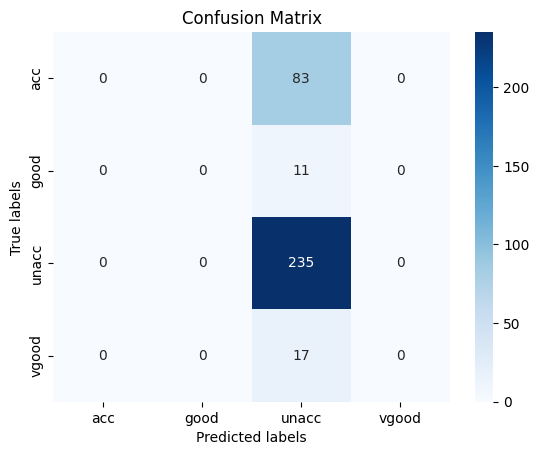

In [188]:
""" Compute the confusion matrix and display it as a heatmap, using only seaborn.
Avoid using matplotlib (here plt.show is not necessary) storing the heatmap to ax
{'acc', 'good', 'unacc', 'vgood'}
"""
cm = confusion_matrix(y_test, y_pred_labels)
print('Confusion matrix:\n', cm)

ax = sns.heatmap(cm, annot=True,
                cmap='Blues', fmt='g',
                xticklabels=['acc', 'good', 'unacc', 'vgood'],
                yticklabels=['acc', 'good', 'unacc', 'vgood'])

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
#sns.show()

If there are no predicted samples for a class,    
it means that the model did not predict that class for any of the samples in the test set that belong to that class.    
The model simply don't have enough information to make accurate predictions for some of the classes.   

In [189]:
""" Check if there are any classes in the test set that have no predicted samples """
## Unique values
true_labels, true_counts = np.unique(y_test, return_counts=True)
pred_labels, pred_counts = np.unique(y_pred, return_counts=True)

missing_labels = np.setdiff1d(true_labels, pred_labels)
print(f'true_labels: {true_labels}')
print(f'true_counts: {true_counts}')
print(f'pred_labels: {pred_labels}')
print(f'pred_counts: {pred_counts}')
print('Classes with no predicted samples:', missing_labels[0])

true_labels: [0 1 2 3]
true_counts: [ 83  11 235  17]
pred_labels: [0.03437775 0.03447241 0.03453805 ... 0.7095631  0.70982456 0.7102023 ]
pred_counts: [1 1 1 ... 1 1 1]
Classes with no predicted samples: 0
